In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo, z_at_value
import coop_post_processing as cpp
from scipy import ndimage
import coop_setup_funcs as csf
import warnings
from astropy.visualization import quantity_support
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
# set plot params
import matplotlib as mpl
import scipy as sp
mpl.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 3}
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
import healpy as hp

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import stats as st
import sys



In [2]:
def getprofs_orig(pkl,nreg,m):
    y_mean        = pkl['prof_allreg'][:,m]
    y_mean_binned = pkl['binnedprof_allreg'][:,m]
    binned_r      = pkl['binned_r']
    npks_reg      = np.asarray([pkl['npks_reg{:d}'.format(reg)] for reg in range(nreg)])
    npks_tot      = pkl['npks_total']
    ys_all_regions_full = []
    ys_all_regions_binned = []
    for reg in range(nreg):
        y_binned = pkl['binnedprof_reg{:d}'.format(reg)][:,m]
        y = pkl['profs_reg{:d}'.format(reg)][:,m]
        ys_all_regions_binned.append(y_binned)
        ys_all_regions_full.append(y)
    weights = npks_reg / np.average(npks_reg)
    covmat_binned, cormat_binned = cpp.covariances(ys_all_regions_binned, weights, nreg)
    covmat_full, cormat_full = cpp.covariances(ys_all_regions_full, weights, nreg)
    errors_binned = np.sqrt(np.diag(covmat_binned))
    errors_full = np.sqrt(np.diag(covmat_full))
    return(np.arange(len(y_mean)), y_mean, covmat_full, cormat_full, errors_full, binned_r, y_mean_binned, covmat_binned, cormat_binned, errors_binned, npks_tot)


In [3]:
# Define the distance bins
dbins = [[893, 1393], [1493, 1993], [2093, 2593], [2693,3193]]
for dbin in dbins:
    print(z_at_value(cosmo.comoving_distance, (dbin[0]-50)*u.Mpc),z_at_value(cosmo.comoving_distance, (dbin[1]+50)*u.Mpc))

zbins = ['0pt20_0pt36', '0pt36_0pt53', '0pt53_0pt72', '0pt72_0pt94'] # the z bins for number density maps
actpath  = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/"
buzzpath = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/"
mask =  "/mnt/raid-cita/mlokken/data/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask_hpx_4096.fits"

0.19985555905328484 redshift 0.3565167560560754 redshift
0.3565167560560754 redshift 0.5289988643902372 redshift
0.5289988643902372 redshift 0.7215854982816572 redshift
0.7215854982816572 redshift 0.9396687416637612 redshift


## First we will work with the fiducial setup:
- $\nu>2$, $e>0.3$
- 24 regions
- $\lambda>20$
- Orient with Hessian, X and Y positive gradients flipped towards horizontal / vertical
- 75 \% of Maglim data for orientation, 25 \% goes into number density maps

In [4]:
nu_e_cuts = True
if nu_e_cuts:
    pt_selection_str = 'nugt2_egtpt3_'
else:
    pt_selection_str = ''
nreg = 24


## 1) Find out if region-weighting is necessary for the y map analysis

In [5]:
# Define a few functions for this test only
def reorder_wgts(wgtfile, acterrs):
    region_weights = np.loadtxt(wgtfile)
    actreg = np.asarray(acterrs['region']).astype(int)
    wgtlist = []
    for r in actreg:
        where = region_weights[:,0] == r
        w = region_weights[where][:,1]
        wgtlist.extend(w)
    return wgtlist

def errs_w_spatial_wgts(pkl,nreg,m, spatial_wgts):
    npks_reg = pkl['npks_list']
    ys_all_regions_full = []
    ys_all_regions_binned = []
    for reg in range(nreg):
        y_binned = pkl['binnedprof'][reg][:,m]
        y = pkl['prof'][reg][:,m]
        ys_all_regions_binned.append(y_binned)
        ys_all_regions_full.append(y)
    weights = npks_reg / np.average(npks_reg)
    weights *=spatial_wgts
    covmat_binned, cormat_binned = cpp.covariances(ys_all_regions_binned, weights, nreg)
    covmat_full, cormat_full = cpp.covariances(ys_all_regions_full, weights, nreg)
    errors_binned = np.sqrt(np.diag(covmat_binned))
    errors_full = np.sqrt(np.diag(covmat_full))
    return(covmat_full, cormat_full, errors_full, covmat_binned, cormat_binned, errors_binned, np.sum(npks_reg))



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


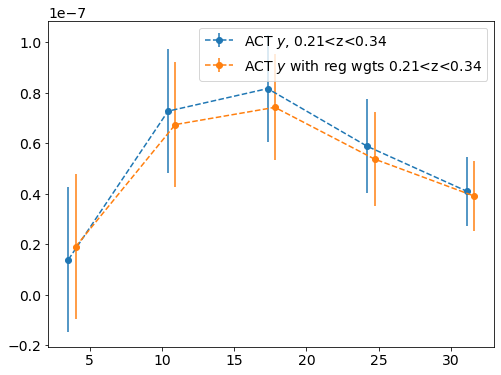

<Figure size 576x432 with 0 Axes>

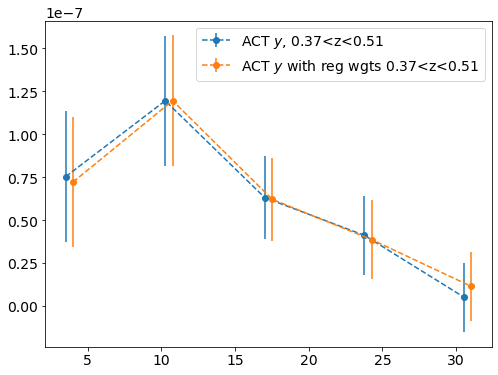

<Figure size 576x432 with 0 Axes>

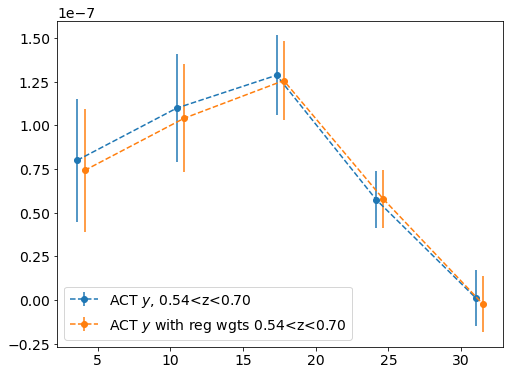

<Figure size 576x432 with 0 Axes>

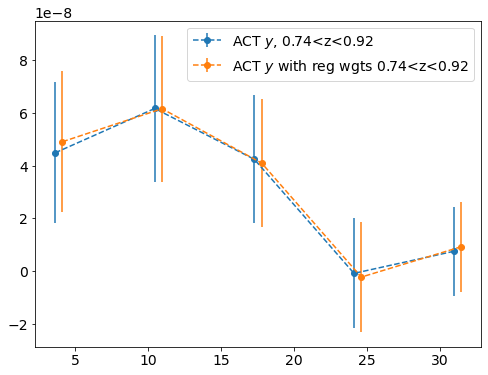

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

In [6]:
m=2
c=0
for dbin in dbins:
    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    mapstr = f'ilc_SZ_deproj_cib_yy_4096_hpx'
    actfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg)
    acterrs   = np.load(actfile, allow_pickle=True)
    profs = np.asarray(acterrs['prof'])
    act_cibd = cpp.Stack_object(img_splits=acterrs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=np.asarray(acterrs['npks_list']).flatten(), rad_in_Mpc=acterrs['rad_in_Mpc'][4].value)
    act_cibd.bin_and_get_stats(7) #Mpc
    plt.errorbar(act_cibd.r_binned, act_cibd.avg_profiles_binned[m], yerr=act_cibd.errors_binned[m], fmt='o', linestyle='--', label='ACT $y$, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
    wlist = reorder_wgts("/home/mlokken/oriented_stacking/act_only_code/noise_analysis/weights_24_regions_ACT_ilc_SZ_deproj_cib_yy_DES_redmapper_lambdagt20.txt", acterrs)
    act_cibd.set_split_wgts(additional_weights=wlist)
    act_cibd.set_average_profiles()
    act_cibd.bin_and_get_stats(7)
    plt.errorbar(act_cibd.r_binned+.5, act_cibd.avg_profiles_binned[m], yerr=act_cibd.errors_binned[m], fmt='o', linestyle='--', label='ACT $y$ with reg wgts {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value, color='orange'))
    plt.legend()
    plt.show()
    plt.clf()
    
    
    
    # plt.legend()
    # plt.ylabel("$y$")
    # plt.title(f"m={m}")
    # plt.xlabel("r [Mpc]")
    plt.show()
    plt.clf()
    # c+=1
    

Result: The errorbars are on average ~6% smaller for m=0, really similar otherwise

## 2) CIB deprojection: Compare CIB deprojected with nothing-deprojected

Red. chi-squared between fiducial CIB-deproj and no-deproj:
z=[0.21,0.34], m=3, chi_red= 0.03999301600775956


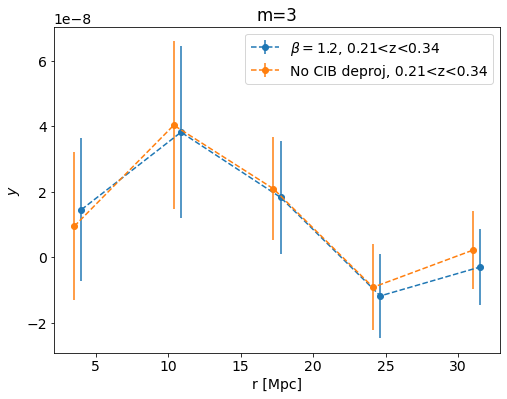

z=[0.21,0.34], m=4, chi_red= 0.015509519993846583


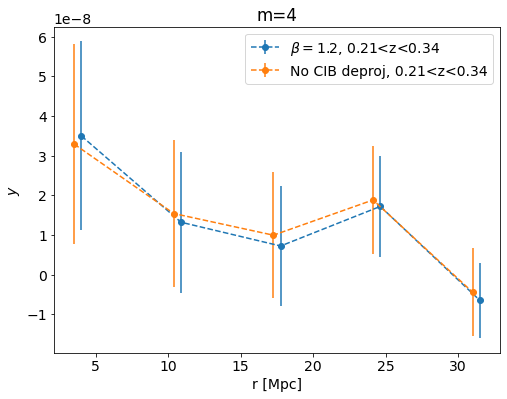

z=[0.37,0.51], m=3, chi_red= 0.4664313628046395


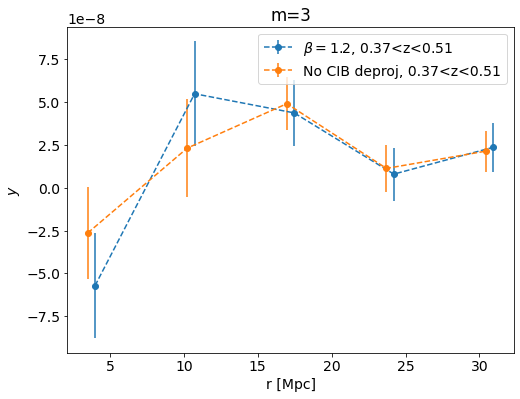

z=[0.37,0.51], m=4, chi_red= 0.12965672228011887


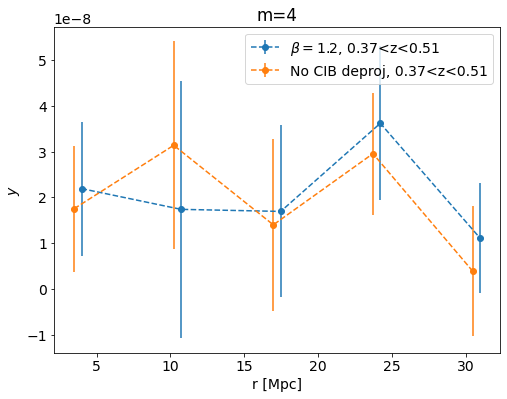

z=[0.54,0.70], m=3, chi_red= 0.07685636410342794


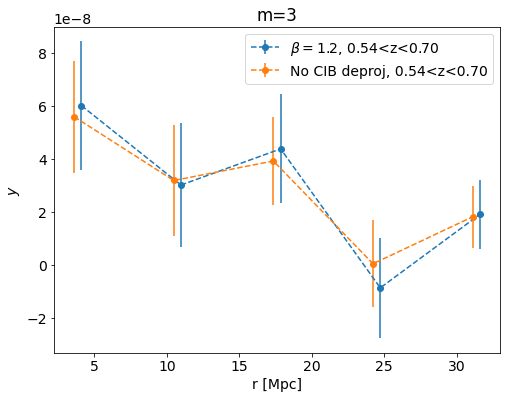

z=[0.54,0.70], m=4, chi_red= 0.1739813520932063


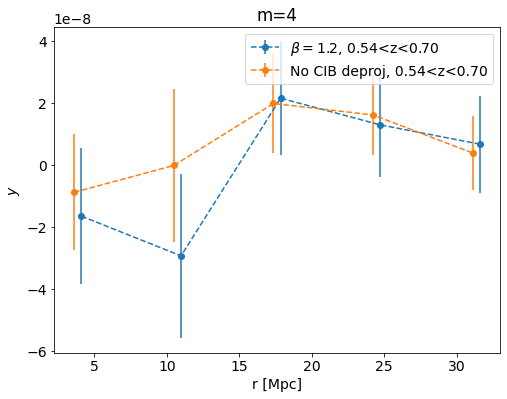

z=[0.74,0.92], m=3, chi_red= 0.9144586956292307


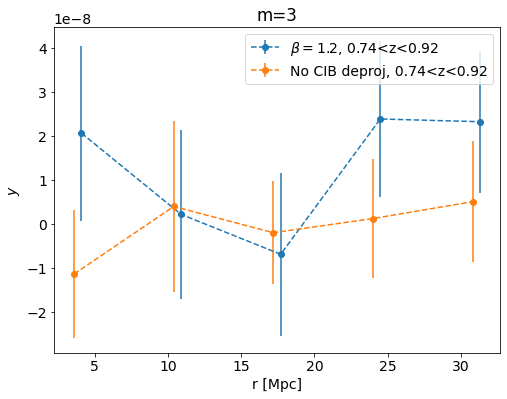

z=[0.74,0.92], m=4, chi_red= 0.22898299801244756


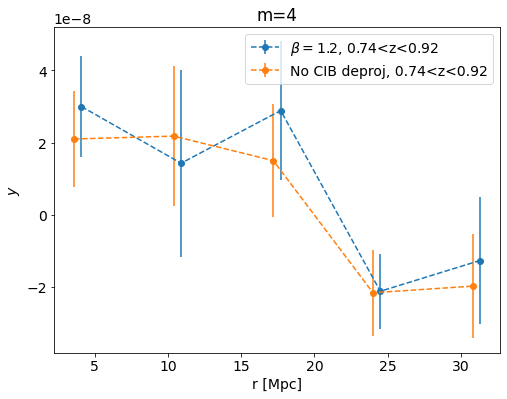

<Figure size 576x432 with 0 Axes>

In [16]:
# Comparing CIB-deprojected vs nothing-deprojected (deleted this run)
nu_e_cuts = True
if nu_e_cuts:
    pt_selection_str = 'nugt2_egtpt3_'
else:
    pt_selection_str = ''
nreg = 24

b = 7
print("Red. chi-squared between fiducial CIB-deproj and no-deproj:")

for c,dbin in enumerate(dbins):
    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    mapstr = f'ilc_SZ_deproj_cib_yy_4096_hpx'
    actfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg)
    acterrs = np.load(actfile, allow_pickle=True)
    profs = np.asarray(acterrs['prof'])
    act_cibd_fid = cpp.Stack_object(img_splits=acterrs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=acterrs['npks_list'], rad_in_Mpc=40)
    act_cibd_fid.bin_and_get_stats(b) #Mpc

    # mapstr = f'ilc_SZ_deproj_cib_cibdBeta_1.15_24.00_yy_4096_hpx'
    # actfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg)
    # acterrs = np.load(actfile, allow_pickle=True)
    # profs = np.asarray(acterrs['prof'])
    # act_cibd_1p15 = cpp.Stack_object(img_splits=acterrs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=acterrs['npks_list'], rad_in_Mpc=40)
    # act_cibd_1p15.bin_and_get_stats(b) #Mpc
    # plt.errorbar(act_cibd_1p15.r_binned-.5, act_cibd_1p15.avg_profiles_binned[m], yerr=act_cibd_1p15.errors_binned[m], fmt='o', linestyle='--', label=r'$\beta=1.15 + d\beta$, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))

    mapstr = f'ilc_SZ_yy_4096_hpx'
    actfile = "/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg)
    acterrs   = np.load(actfile, allow_pickle=True)
    profs = np.asarray(acterrs['prof'])
    act_cibd_nodeproj = cpp.Stack_object(img_splits=acterrs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=acterrs['npks_list'], rad_in_Mpc=40)
    act_cibd_nodeproj.bin_and_get_stats(b) #Mpc

    
    nbin = len(act_cibd_fid.r_binned)
    dof = nbin-1
    # get the chi squared between each of these
    for m in range(5):
        print("z=[{:.2f},{:.2f}], m={:d}, chi_red=".format(zlow.value, zhi.value, m), st.chisq(act_cibd_fid.avg_profiles_binned[m], act_cibd_nodeproj.avg_profiles_binned[m], act_cibd_fid.covmat_binned[m], act_cibd_nodeproj.covmat_binned[m])/dof)
        plt.errorbar(act_cibd_fid.r_binned+.5, act_cibd_fid.avg_profiles_binned[m], yerr=act_cibd_fid.errors_binned[m], fmt='o', linestyle='--', label=r'$\beta=1.2$, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
        plt.errorbacosmologyislife1r(act_cibd_nodeproj.r_binned, act_cibd_nodeproj.avg_profiles_binned[m], yerr=act_cibd_nodeproj.errors_binned[m], fmt='o', linestyle='--', label=r'No CIB deproj, {:.2f}<z<{:.2f}'.format(zlow.value, zhi.value)) 
        plt.legend()
        plt.ylabel("$y$")
        plt.title(f"m={m}")
        plt.xlabel("r [Mpc]")
        plt.show()
        plt.clf()
        
    # chi squared with respect to null
    # null_vector = np.zeros(len(act_cibd_fid.avg_profiles_binned[m]))
    # print(np.sqrt(st.chisq(act_cibd_fid.avg_profiles_binned[m], null_vector, act_cibd_fid.covmat_binned[m])/4.), np.sqrt(st.chisq(act_cibd_1p15.avg_profiles_binned[m], null_vector, act_cibd_1p15.covmat_binned[m])/4.), np.sqrt(st.chisq(act_cibd_nodeproj.avg_profiles_binned[m], null_vector, act_cibd_nodeproj.covmat_binned[m])/4.))

    # print("SNR from PTE", st.snr_from_pte(act_cibd_fid.avg_profiles_binned[m], np.zeros(len(act_cibd_fid.avg_profiles_binned[m])), act_cibd_fid.covmat_binned[m]))
    # plt.imshow(act_cibd_fid.covmat_binned[m])
    # plt.colorbar()
    # plt.show()
    # plt.clf()
    

The following (commented) cell checks whether averaging the profiles from separate regions, weighted by npks, is equivalent to stacking a single time over the full map. It is perfect.

In [9]:
# # Making sure errors make sense

# for dbin in dbins:
#     cl_dlow, cl_dhi = dbin[0], dbin[1]
#     dlow   = cl_dlow-50
#     dhi    = cl_dhi+50
#     zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
#     zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
#     print(zlow, zhi)
#     mapstr = "ilc_SZ_deproj_cib_yy_4096_hpx"
#     errs   = np.load("/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg), allow_pickle=True)
#     full   = np.load("/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg), allow_pickle=True)
#     profs = np.asarray(errs['prof'])
#     act = cpp.Stack_object(img_splits=errs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=errs['npks_list'], rad_in_Mpc=40)
#     act.bin_and_get_stats(5.7) #Mpc
    
#     for m in [0,2,4]:
#         plt.plot(full['binned_r'], full['binnedprof'][:,m], 'blue', label='Full stack')
#         plt.fill_between(act.r_binned, act.avg_profiles_binned[m]-act.errors_binned[m]*np.sqrt(act.Nsamples), act.avg_profiles_binned[m]+act.errors_binned[m]*np.sqrt(act.Nsamples), color='blue', alpha=.5)
#         is_beyond_1sigma = []
#         for reg in range(24):
#             plt.plot(act.r_binned, act.profile_splits_binned[m][reg], '.6', alpha=.5)
#             is_beyond_1sigma.append(np.abs(act.profile_splits_binned[m][reg]-act.avg_profiles_binned[m]) > act.errors_binned[m]*np.sqrt(act.Nsamples))
#         plt.plot(act.r_binned, act.avg_profiles_binned[m], 'k', label='Average of regions (unwgt)')

#         print()
#         if m==0:
#             plt.ylim([-5e-7, 1e-6])
#         if m==2:
#             plt.ylim([-8e-8, 8e-7])
#         if m==4:
#             plt.ylim([-5e-7, 5e-7])
#         plt.legend()
#         plt.show()
#         plt.clf()
#         print("Fraction of regions beyond 1 sigma", np.sum(np.asarray(is_beyond_1sigma),axis=0)/24.)

    


### Plot new result from full z against paper I results

[ 14  89 164 239]


Number exceeding:  22731
2.277925780146064 9.807903472749924
Number exceeding:  543
3.45859536646638 10.051046598874219
Number exceeding:  141952
1.4685606298132066 5.915592497483043


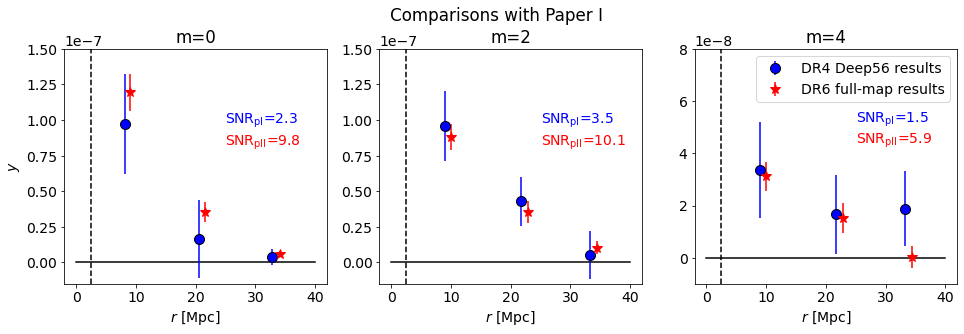

<Figure size 576x432 with 0 Axes>

In [18]:
# First, grab paper I results
act_img = np.loadtxt("/mnt/scratch-lustre/mlokken/stacking/ACT+Planck/ACTxDES_lambdagt10_1032_2632Mpc_18pt0Mpc_smth_16regallreg_combined_stack.txt")
arcmin_per_pix = .5
z = z_at_value(cosmo.comoving_distance, (1032+1232)/2.*u.Mpc)
mpc_per_arcmin = cosmo.kpc_comoving_per_arcmin(z).to(u.Mpc/u.arcmin)
rad_in_pix = 240
rad_in_Mpc = rad_in_pix * arcmin_per_pix * mpc_per_arcmin
mpc_per_pix = rad_in_Mpc / (act_img.shape[0]//2)
pkl_c  = "/mnt/scratch-lustre/mlokken/sim_ymaps/ACTxDES_lambdagt10_1032_2632Mpc_13pt9Mpc_nugt2_egtpt3_smth_m0to5_profiles_126maps.pkl"
sims_c = np.load(pkl_c, allow_pickle=True)
buzzard_profs_cuts   = np.load("/mnt/scratch-lustre/mlokken/stacking/Buzzard_tSZ_rmpks/Buzzard_lambdagt10_1032_2632Mpc_17pt8Mpc_nugt2_egtpt3_smth_24reg_m0to5_profiles.pkl", allow_pickle=True)
actxdes_profs_cuts   = np.load("/mnt/scratch-lustre/mlokken/stacking/ACT+Planck/ACTxDES_lambdagt10_1032_2632Mpc_17pt8Mpc_nugt2_egtpt3_smth_12reg_m0to5_profiles.pkl", allow_pickle=True)
npks_bc   = buzzard_profs_cuts['npks_total']
npks_ac   = actxdes_profs_cuts['npks_total']
nreg_b_cuts   = 24
nreg_a_cuts   = 12

# now grab full DR6 results (note that there is z-bin sandwiching here and the z coverage is slightly different)
pkl  = np.load(actpath + "ilc_SZ_yy_4096_hpx_redmapper_lambdagt10_combined_1093_2593Mpc_nugt2_egtpt3_17pt8_orient_100pct_redmagic_1043_2643Mpc_24reg_m0to5_profiles.pkl", allow_pickle=True)
profs = np.asarray(pkl['prof'])
y_sym_dr6_rm_lgt10full = cpp.Stack_object(img_splits=pkl['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=pkl['npks_list'], rad_in_Mpc=40)

for r in range(y_sym_dr6_rm_lgt10full.profile_splits.shape[1]):
    y_sym_dr6_rm_lgt10full.profile_splits[0,r,:] -= np.average(y_sym_dr6_rm_lgt10full.profile_splits[0,r,:][199:])
y_sym_dr6_rm_lgt10full.set_average_profiles()
y_sym_dr6_rm_lgt10full.bin_and_get_stats(8) #Mpc
pII_r_pix = len(y_sym_dr6_rm_lgt10full.r)

fig, ax= plt.subplots(nrows=1, ncols=3, figsize=[16,4.5])
for n,m in enumerate([0,2,4]):
    if m==0:
        pix_bins=(np.arange(15, 240+225/3., 225/3.)).astype(int)
        pix_binsII = (np.arange(15, 240+225/3., 225/3.)*(pII_r_pix/rad_in_pix)).astype(int) # scale bins to the new shape
        print(pix_binsII)
    if m==2:
#         pix_bins = (np.arange(0, 240+240/3., 240/3.)).astype(int)
        pix_bins = np.array([15,100,170,240])
        pix_binsII = (np.array([15,100,170,240])*(pII_r_pix/rad_in_pix)).astype(int)
    if m==4:
        pix_bins = [15,100,170,240]
        pix_binsII = (np.array([15,100,170,240])*(pII_r_pix/rad_in_pix)).astype(int)
    
    # covmat full from sim
    r, y_mean_sim_c, covmat_sim_14_c_full, cormat_full_c, errors_full_c, ignore, ignore, ignore, ignore, ignore, ignore = cpp.getprofs_sims(sims_c, 126, m)
    # Buzzard covmat, full
    r, y_mean_b_cuts, covmat_bc_full, cormat_bc_full, errors_full_bc, finebinned_r_b_cuts, y_mean_b_cuts_finebins, covmat_bc_fine, cormat_bc_fine, errors_bc_fine, npks_tot_bc = getprofs_orig(buzzard_profs_cuts, nreg_b_cuts, m)
    # full ACT data
    r, y_mean_ac_full = getprofs_orig(actxdes_profs_cuts, nreg_a_cuts, m)[0:2]
    
    covmat_full_data_c = covmat_sim_14_c_full*1103/975 + npks_bc/npks_ac * covmat_bc_full
    binned_r_cuts, y_mean_binned_ac, covmat_ac, cormat_ac, errors_ac, npks_ac = cpp.getbinnedprofs_custombins(actxdes_profs_cuts, nreg_a_cuts, pix_bins, m, mpc_per_pix, covmat_full=covmat_full_data_c)
    binned_r, y_mean_sim_14_c, covmat_sim_14_c, cormat_sim_14_c, errors_sim_14_c, npks_tot_sim_c = cpp.getbinnedprofs_custombins_sims(sims_c, 122, pix_bins, m, mpc_per_pix, covmat_full=covmat_sim_14_c_full)
    binned_r_cuts, y_mean_binned_bc, covmat_bc, cormat_bc, errors_bc, npks_bc = cpp.getbinnedprofs_custombins(buzzard_profs_cuts, nreg_b_cuts, pix_bins, m, mpc_per_pix)

    if m==0:
        y_mean_binned_ac = np.asarray(y_mean_binned_ac)-np.average(y_mean_ac_full[200:])
        y_mean_binned_bc = np.asarray(y_mean_binned_bc)-np.average(y_mean_b_cuts[200:])
    covmat_sim_18_c = covmat_sim_14_c*1103/975.+covmat_bc*(npks_bc/npks_ac)
    errors_sim_18_c = np.sqrt(np.diag(covmat_sim_18_c))
    before = y_sym_dr6_rm_lgt10full.profile_splits_binned[m]
    y_sym_dr6_rm_lgt10full.set_custom_bin_m_avg(m, pix_binsII)
    y_sym_dr6_rm_lgt10full.set_custom_bin_m_splits(m, pix_binsII)
    y_sym_dr6_rm_lgt10full.set_covariance_binned()


    
    if m==4:
        ylims = [-1e-8, 8e-8]
    elif m==2 or m==0:
        ylims = [-1.5e-8, 1.5e-7]
    ax[n].set_ylim(ylims)
    
    ax[n].plot([0,40],[0,0],'k')
    # ax1.errorbar(binned_r_cuts.value+.5, y_mean_binned_bc, yerr=errors_bc, marker='^', c='r', mec='k', fmt='o', markersize=10, label='Buzzard')
    ax[n].errorbar(binned_r_cuts.value-.5, y_mean_binned_ac, yerr=errors_sim_18_c, marker='o', c='b', mec='k', fmt='o', markersize=10, label='DR4 Deep56 results')
    ax[n].errorbar(y_sym_dr6_rm_lgt10full.r_binned+.5, y_sym_dr6_rm_lgt10full.avg_profiles_binned[m], yerr=y_sym_dr6_rm_lgt10full.errors_binned[m], markersize=10, fmt='*', label='DR6 full-map results', c='r')
    ax[n].set_title(f'm={m}')
    ax[n].plot([2.5,2.5],ylims, 'k', linestyle='--')
    # get chi-squared for each
    null_vector = np.zeros(len(y_mean_binned_ac))
    pte_I, snr_I   = st.snr_from_pte(y_mean_binned_ac, null_vector, covmat_sim_18_c, chisq_data=None)
    snr_II = np.sqrt(st.chisq(y_sym_dr6_rm_lgt10full.avg_profiles_binned[m], null_vector, y_sym_dr6_rm_lgt10full.covmat_binned[m]))
    print(snr_I, snr_II)
    # add snr to the plot
    ax[n].text(25,ylims[1]*.65, r'SNR$_{{\mathrm{{pI}}}}$=' '{:.1f}'.format(round(snr_I,1)), fontsize=14, color='b')
    ax[n].text(25, ylims[1]*.55, r'SNR$_{{\mathrm{{pII}}}}$=' '{:.1f}'.format(round(snr_II,1)), fontsize=14, color='r')
    ax[n].set_xlabel("$r$ [Mpc]")
    # ax1.fill_between(finebinned_r_b_cuts.value, y_mean_b_cuts_finebins-errors_bc_fine, y_mean_b_cuts_finebins+errors_bc_fine, alpha = 0.7, color='royalblue')    
ax[0].set_ylabel(r"$y$")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.suptitle("Comparisons with Paper I")
# add a little space vertically
plt.subplots_adjust(top=.85)

plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/y_comparison_PI_PII_m024.pdf")
plt.show()
plt.clf()


# Evolution with Redshift

In [8]:
# y_avg = 1.58e-6 + 8.9e-8+ 9.8e-8 # In case I need it later


 First, no nu and e selection

0.21239516461719793 redshift 0.3429098261022621 redshift
60.12306035750604 7.753906135458827
0.3702330798213221 redshift 0.5139230139548906 redshift
52.0784079155495 7.216537113848268
0.544213697990799 redshift 0.7046457741840516 redshift
82.53866677759285 9.08507934899816
0.7387014476605694 redshift 0.9203650420853864 redshift
34.509789975809625 5.8745033812067575


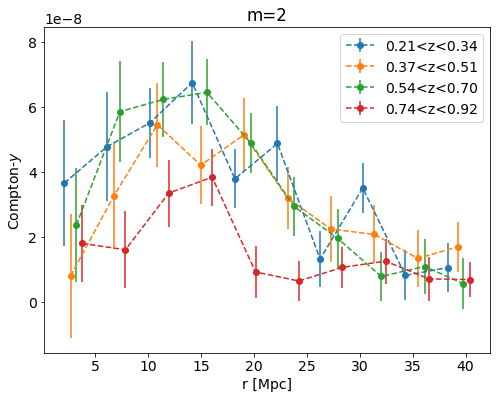

In [9]:
pt_selection_str = ''
c = 0
for dbin in dbins:
    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    print(zlow, zhi)
    errs   = np.load("/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/ilc_SZ_deproj_cib_yy_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orient_100pct_maglim_{:d}_{:d}Mpc_48reg_m0to5_profiles.pkl".format(cl_dlow, cl_dhi, pt_selection_str, dlow, dhi), allow_pickle=True)
    full   = np.load("/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/ilc_SZ_deproj_cib_yy_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orient_100pct_maglim_{:d}_{:d}Mpc_m0to5_profiles.pkl".format(cl_dlow, cl_dhi, pt_selection_str, dlow, dhi), allow_pickle=True)
#     if c==0:
#         plt.imshow(cormat_binned)
#         plt.colorbar()
#         plt.show()
#         plt.clf()
    for m in [2]:
        covmat_full, cormat_full, errors_full, covmat_binned, cormat_binned, errors_binned, npks_tot = cpp.getprofs(errs, 48, m)
        avg = []
        plt.errorbar(full['binned_r']+np.full(len(full['binned_r']),c/2.), full['binnedprof'][:,m], yerr=errors_binned, fmt='o', linestyle='--', label='{:.2f}<z<{:.2f}'.format(zlow.value, zhi.value))
    plt.legend()
    plt.ylabel("Compton-$y$")
    plt.title(f"m={m}")
    plt.xlabel("r [Mpc]")

    null = np.zeros(len(full['binnedprof'][:,m]))
    chisq_y = st.chisq(full['binnedprof'][:,m], null, covmat_binned)
    if m==2:
        snr_y = np.sqrt(chisq_y)
    elif m==4:
        snr_y = st.snr_from_pte( full['binnedprof'][:,m], null, covmat_binned, chisq_y)
    print(chisq_y, snr_y)
    
    
    c+=1
